In [1]:
import os
import pickle
import config
import dnnlib
import dnnlib.tflib as tflib
import gzip
import glob
import json
import numpy as np
from tqdm import tqdm_notebook
import shutil
import warnings
import matplotlib.pylab as plt
%matplotlib inline
warnings.filterwarnings("ignore")
import PIL.Image
from encoder.generator_model import Generator
from PIL import Image
# from scipy.misc import imsave

import keras 
from keras.models import load_model
from keras.preprocessing.image import array_to_img, img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Lambda, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras import regularizers, optimizers, metrics, applications
import math

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import load_img
import dlib
from ffhq_dataset.landmarks_detector import LandmarksDetector

In [3]:
import tensorflow as tf
tf.__version__

'1.14.0'

### load StyleGAN pre-trained model

In [4]:
# generate images
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

# qlatents = np.random.normal(size=(100, 512))
# dlatents = Gs_network.components.mapping.run(qlatents, None, minibatch_size=1, randomize_noise=False, structure='fixed')
# images = Gs_network.components.synthesis.run(dlatents, minibatch_size=1, randomize_noise=False, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), structure='fixed')

# save numpy array
# np.save('qlatents_test.npy', qlatents)
# np.save('dlatents_test.npy', dlatents)
# np.save('images_test.npy', images)

# save generated images to hard disk
# for i in range(100):
#     imsave('./datasets_test/'+str(i)+'.png', images[i])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

### Crop images

(256, 256)


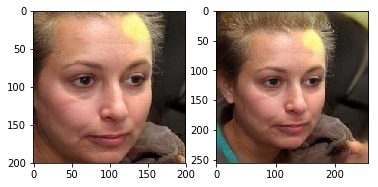

In [3]:
# crop to target size -- example
from keras.preprocessing.image import load_img
imgObj = load_img('./datasets_aligned/256/20.png')
# size = 200,200
# imgObj.thumbnail(size, Image.ANTIALIAS)

width, height = imgObj.size   # Get dimensions
left = 28
top = 28
right = 228
bottom = 228
cropped_example = imgObj.crop((left, top, right, bottom))


print(imgObj.size)
inputImg = img_to_array(imgObj)
x = np.asarray([inputImg])
x = x.astype('float32')
x /= 255
# x = preprocess_input(x)
# print(x)
# pred = model.predict(x) 
# print("%.8f" % pred)
plt.subplot(1, 2, 1)
plt.imshow(cropped_example)
plt.subplot(1, 2, 2)
plt.imshow(imgObj)
plt.show()

AttributeError: 'NoneType' object has no attribute 'left'

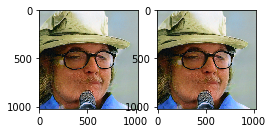

In [129]:
# crop based on landmark -- example
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('dlib.face.landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image('./datasets/9740.png')
# jc_orig = load_image('./raw_images/Scarlett.PNG')

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(200, jc_orig, bb, landmarkIndices=AlignDlib.INNER_EYES_AND_BOTTOM_LIP)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [ ]:
# crop generated images
target_dir = './datasets_aligned/200/200/'
for subdir, dirs, files in os.walk('./datasets'):
    print(len(files))
    for file in files:
#         print(subdir , os.sep , file)
        jc_orig = load_image(subdir + os.sep + file)
        bb = alignment.getLargestFaceBoundingBox(jc_orig)
        jc_aligned = alignment.align(200, jc_orig, bb, landmarkIndices=AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
        if jc_aligned is None:
            print(file)
            continue
        imsave(target_dir+file,jc_aligned)
#         print(target_dir+file)
        
    break

### load dlatents and images

In [ ]:
# load-numpy 10k dataset
qlatents = np.load('qlatents.npy')
dlatents = np.load('dlatents.npy')
images = np.load('images.npy')
print(images.shape)

print(dlatents.shape)

### custom model

In [10]:
# triplet_loss_func
import tensorflow as tf 
def triplet_loss_func(y_true, y_pred, alpha=0.3):
	'''
	Used directly as loss function
		Inputs:
					y_true: True values of classification. (y_train)
					y_pred: predicted values of classification.
					alpha: Distance between positive and negative sample, arbitrarily
						   set to 0.3
		Returns:
					Computed loss
		Function:
					--Implements triplet loss using tensorflow commands
					--The following function follows an implementation of Triplet-Loss 
					  where the loss is applied to the network in the compile statement 
					  as usual.
	'''
	anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

	positive_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), -1)
	negative_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)), -1)

	loss_1 = tf.add(tf.subtract(positive_dist, negative_dist), alpha)
	loss = tf.reduce_sum(tf.maximum(loss_1, 0.0))

	return loss

In [8]:
# load model privided by rama
# Importing all the necessary packages
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Dense, Lambda, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras import regularizers, optimizers, metrics, applications
import math


tensorboard = TensorBoard(log_dir='Classifier/logs/initial_log', histogram_freq=0, write_graph=True, write_images=False)

img_width, img_height = 224, 224
sgd = optimizers.SGD(lr=0.0,momentum = 0.9, decay = 0.0,  clipvalue=0.5)

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print(lrate)
    return lrate

lrate = LearningRateScheduler(step_decay)
    
def MinPooling2D(x):
    #lambda for negative tensor
    minus_x = Lambda(lambda x : -x)(x)
    minpooled_x = MaxPooling2D(pool_size = (2,2))(minus_x)
    output = Lambda(lambda x: -x)(minpooled_x)
    return output

def create_model():
    
    #common layers
    inputs = Input(shape=(img_width, img_height, 3))
    conv2d1 = Conv2D(32, (3, 3), activation='relu')(inputs)
    batchnorm1 = BatchNormalization()(conv2d1)
    maxpool1 = MaxPooling2D(pool_size = (2, 2))(batchnorm1)
    conv2d2 = Conv2D(32, (3, 3), activation='relu')(maxpool1)
    batchnorm2 = BatchNormalization()(conv2d2)
    maxpool2 = MaxPooling2D(pool_size = (2, 2))(batchnorm2)
    #dropout1 = Dropout(0.3)(batchnorm2)

#    conv2d3 = Conv2D(64, (3, 3), activation='relu')(dropout1)
#    batchnorm3 = BatchNormalization()(conv2d3)
#    conv2d4 = Conv2D(64, (3, 3), activation='relu')(batchnorm3)
#    batchnorm4 = BatchNormalization()(conv2d4)
#    dropout2 = Dropout(0.3)(batchnorm4)
    
    
    # Minpooling layers
    conv2d5_1 = Conv2D(128, (3, 3), activation='relu')(maxpool2)
    batchnorm5_1 = BatchNormalization()(conv2d5_1)
    minpool2d1 = MinPooling2D(batchnorm5_1)
    conv2d6_1 = Conv2D(128, (3, 3), activation='relu')(minpool2d1)
    batchnorm6_1 = BatchNormalization()(conv2d6_1)
    minpool2d2 = MinPooling2D(batchnorm6_1)
#    dropout3_1 = Dropout(0.3)(minpool2d1)

#    conv2d7_1 = Conv2D(256, (3, 3), activation='relu')(dropout3_1)
#    batchnorm7_1 = BatchNormalization()(conv2d7_1)
#    conv2d8_1 = Conv2D(256, (3, 3), activation='relu')(batchnorm7_1)
#    batchnorm8_1 = BatchNormalization()(conv2d8_1)
#    minpool2d2 = MinPooling2D(batchnorm8_1)
    
    
    # Maxpooling layers
    conv2d5_2 = Conv2D(128, (3, 3), activation='relu')(maxpool2)
    batchnorm5_2 = BatchNormalization()(conv2d5_2)
    maxpool2d1 = MaxPooling2D(pool_size = (2,2))(batchnorm5_2)
    conv2d6_2 = Conv2D(128, (3, 3), activation='relu')(maxpool2d1)
    batchnorm6_2 = BatchNormalization()(conv2d6_2)
    maxpool2d2 = MaxPooling2D(pool_size = (2,2))(batchnorm6_2)
#    dropout3_2 = Dropout(0.3)(maxpool2d1)
#
#    conv2d7_2 = Conv2D(256, (3, 3), activation='relu')(dropout3_2)
#    batchnorm7_2 = BatchNormalization()(conv2d7_2)
#    conv2d8_2 = Conv2D(256, (3, 3), activation='relu')(batchnorm7_2)
#    batchnorm8_2 = BatchNormalization()(conv2d8_2)
#    maxpool2d2 = MaxPooling2D(pool_size = (2,2))(batchnorm8_2)
#    
    
    # Avgpooling layers
    conv2d5_3 = Conv2D(128, (3, 3), activation='relu')(maxpool2)
    batchnorm5_3 = BatchNormalization()(conv2d5_3)
    avgpool2d1 = AveragePooling2D(pool_size = (2,2))(batchnorm5_3)
    conv2d6_3 = Conv2D(128, (3, 3), activation='relu')(avgpool2d1)
    batchnorm6_3 = BatchNormalization()(conv2d6_3)
    avgpool2d2 = AveragePooling2D(pool_size = (2,2))(batchnorm6_3)
#    dropout3_3 = Dropout(0.3)(avgpool2d1)
#
#    conv2d7_3 = Conv2D(256, (3, 3), activation='relu')(dropout3_3)
#    batchnorm7_3 = BatchNormalization()(conv2d7_3)
#    conv2d8_3 = Conv2D(256, (3, 3), activation='relu')(batchnorm7_3)
#    batchnorm8_3 = BatchNormalization()(conv2d8_3)
#    avgpool2d2 = AveragePooling2D(pool_size = (2,2))(batchnorm8_3)
#    
    #Concatenation of three feature matrix
    concat_layer = Concatenate()([maxpool2d2, minpool2d2, avgpool2d2])
    
    #final_layer
    final_layer = Conv2D(128, (3,3), activation = "relu")(concat_layer)
    final_layer = BatchNormalization()(final_layer)
    final_layer = MaxPooling2D(pool_size = (2,2))(final_layer)

    x = Flatten()(final_layer)
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)

    # Creating the final model
    model_final = Model(input=inputs, output=predictions)

    # Compile the model
    model_final.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#     model_final.compile(optimizer=sgd, loss=triplet_loss_func, metrics=['accuracy'])
    return model_final

In [7]:
# hyber parameters
batch_size = 8
epochs = 40

nb_samples = 23201 # 23231
nb_train_samples = 20481 #20511
nb_validation_samples = 2720

validation_accuracy = 0

model_final = create_model()
print(model_final.summary())

print('Model compilation successful.....')
print('\n')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 222, 222, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
# Initiate the train and test generators with data augmentation
train_datagen = ImageDataGenerator( #rescale=1. / 255)
        rescale=1. / 255,
        horizontal_flip=True,
        #vertical_flip=True,
        fill_mode="nearest",
        zoom_range = 0.1,
        #shear_range = 0.2,
        #channel_shift_range= 0.2,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        rotation_range=25
    )


train_generator = train_datagen.flow_from_directory(
        "Train",
        target_size = (img_height, img_width),
        batch_size=batch_size,
        color_mode='rgb',
        shuffle=True,
        #save_to_dir="Augmented",
        #save_prefix="aug",
        #save_format="jpg",
        #class_mode="categorical"
    )



NameError: name 'batch_size' is not defined

In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255)
        #rescale=1. / 255,
        #horizontal_flip=True,
        #vertical_flip=True,
        #fill_mode="nearest",
        #zoom_range = 0.1,
        #shear_range = 0.2,
        #channel_shift_range= 0.2,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #rotation_range=40
    #)
validation_generator = validation_datagen.flow_from_directory(
        "Val",
        target_size = (img_height, img_width),
        batch_size=batch_size,
        color_mode='rgb',
        shuffle=True,
        #save_to_dir="Augmented",
        #save_prefix="aug",
        #save_format="jpg",
        #class_mode="categorical"
    )


Found 2720 images belonging to 2 classes.


In [9]:
filepath = "weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_acc", verbose = 1, save_best_only = True, mode = "max")
early_stop = EarlyStopping(monitor = "val_loss", patience = 2)
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.01, patience=2, verbose=1, epsilon=1e-4, mode='min')
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
model_final.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples,
        callbacks=[tensorboard, checkpoint, early_stop, reduce_lr_loss, lrate])

score = model_final.evaluate_generator(validation_generator, nb_validation_samples // batch_size)

v = score[1] * 100
validation_accuracy += v

validation_accuracy = validation_accuracy
print(validation_accuracy)

Epoch 1/40
0.001
2563/2563 [==============================] - 707s 276ms/step - loss: 12.9852 - acc: 0.7463 - val_loss: 7.7198 - val_acc: 0.7489

Epoch 00001: val_acc improved from -inf to 0.74890, saving model to weights.h5
Epoch 2/40
0.001
2563/2563 [==============================] - 469s 183ms/step - loss: 4.9857 - acc: 0.8037 - val_loss: 3.0571 - val_acc: 0.8246

Epoch 00002: val_acc improved from 0.74890 to 0.82463, saving model to weights.h5
Epoch 3/40
0.0005
2563/2563 [==============================] - 472s 184ms/step - loss: 2.4948 - acc: 0.8286 - val_loss: 1.9887 - val_acc: 0.8419

Epoch 00003: val_acc improved from 0.82463 to 0.84191, saving model to weights.h5
Epoch 4/40
0.0005
2563/2563 [==============================] - 441s 172ms/step - loss: 1.6826 - acc: 0.8343 - val_loss: 1.3595 - val_acc: 0.8540

Epoch 00004: val_acc improved from 0.84191 to 0.85404, saving model to weights.h5
Epoch 5/40
0.0005
2563/2563 [==============================] - 442s 173ms/step - loss: 1.190

### load classifiy.h5, which is trained on UTKFace

In [149]:
model = load_model('classify.h5')
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = datagen.flow_from_directory(
#     directory='datasets_aligned/crop',
    directory='datasets/',
    target_size=(224,224), 
    # classes=[0,1,2], 
#     class_mode='binary', 
    batch_size=8, 
    shuffle=True,
#     seed=42,
    color_mode='rgb',
    subset='training'
    )
valid_generator = datagen.flow_from_directory(
    directory='datasets_aligned/crop',
    target_size=(224,224), 
    # classes=[0,1,2], 
#     class_mode='binary', 
    batch_size=8, 
    shuffle=True,
#     seed=42,
    color_mode='rgb',
    subset='validation'
    )
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30)

Found 7907 images belonging to 2 classes.
Found 1975 images belonging to 2 classes.
Epoch 1/30
988/988 [==============================] - 258s 261ms/step - loss: 0.8822 - acc: 0.6712 - val_loss: 0.8359 - val_acc: 0.6509
Epoch 2/30
988/988 [==============================] - 90s 91ms/step - loss: 0.6860 - acc: 0.7295 - val_loss: 0.6294 - val_acc: 0.7605
Epoch 3/30
988/988 [==============================] - 55s 56ms/step - loss: 0.6010 - acc: 0.7552 - val_loss: 0.6136 - val_acc: 0.7483
Epoch 4/30
988/988 [==============================] - 66s 67ms/step - loss: 0.5819 - acc: 0.7616 - val_loss: 0.5538 - val_acc: 0.7809
Epoch 5/30
988/988 [==============================] - 64s 64ms/step - loss: 0.5569 - acc: 0.7772 - val_loss: 2.7439 - val_acc: 0.4016
Epoch 6/30
988/988 [==============================] - 66s 66ms/step - loss: 0.5559 - acc: 0.7771 - val_loss: 0.5367 - val_acc: 0.7839
Epoch 7/30
988/988 [==============================] - 77s 78ms/step - loss: 0.5417 - acc: 0.7828 - val_loss: 0

### load chubby.pkl

In [2]:
import pickle

In [3]:
chubby_model = pickle.load(open('celeba_classifier/celebahq-classifier-17-chubby.pkl', 'rb'))

AttributeError: module 'tensorflow' has no attribute 'Dimension'

In [68]:
chubby_model.print_layers()


celebahq-classifier-17-chubby  Params    OutputShape         WeightShape     
---                            ---       ---                 ---             
images_in                      -         (?, 3, 256, 256)    -               
labels_in                      -         (?, 0)              -               
lod                            -         ()                  -               
FromRGB_lod0                   256       (?, 64, 256, 256)   (1, 1, 3, 64)   
256x256/Conv0                  36928     (?, 64, 256, 256)   (3, 3, 64, 64)  
256x256/Conv1_down             73856     (?, 128, 128, 128)  (3, 3, 64, 128) 
128x128/Conv0                  147584    (?, 128, 128, 128)  (3, 3, 128, 128)
128x128/Conv1_down             295168    (?, 256, 64, 64)    (3, 3, 128, 256)
64x64/Conv0                    590080    (?, 256, 64, 64)    (3, 3, 256, 256)
64x64/Conv1_down               1180160   (?, 512, 32, 32)    (3, 3, 256, 512)
32x32/Conv0                    2359808   (?, 512, 32, 32)    (3

In [70]:
type(chubby_model)

dnnlib.tflib.network.Network

In [69]:
chubby_probabilities = chubby_model.run(X_data.reshape(-1, 18*512))

AttributeError: 'Network' object has no attribute 'predict_generator'

### Predict labels

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
img_width, img_height = 224, 224
test_generator = test_datagen.flow_from_directory(
        "datasets_aligned/200/",
        target_size = (img_height, img_width),
        batch_size=1,
        color_mode='rgb',
        shuffle=False)

Found 9882 images belonging to 1 classes.


In [10]:
#predict images
probabilities = model_final.predict_generator(test_generator, 9882)

In [11]:
np.save('probabilities.npy', probabilities)

In [7]:
probabilities = np.load('probabilities.npy')

In [8]:
weight_predict = np.zeros((9882, 1))
file_index_fat =[]
file_index_thin = []
for index, item in enumerate(probabilities):
    if item[0] <0.5:
        weight_predict[index]=0
        file_index_thin.append(index)
    else:
        weight_predict[index]=1
        file_index_fat.append(index)

### file_fat, file_thin are predicted by model

In [9]:
file_index = [int(i[4:-4]) for i in test_generator.filenames]
len(file_index)

9882

In [10]:
file_fat =  np.asarray(file_index)[file_index_fat]
file_thin =  np.asarray(file_index)[file_index_thin]

In [11]:
file_fat.shape

(5932,)

### overlapped set

In [76]:
unable_crop = list(set(range(10000)) - set(file_fat)- set(file_thin))

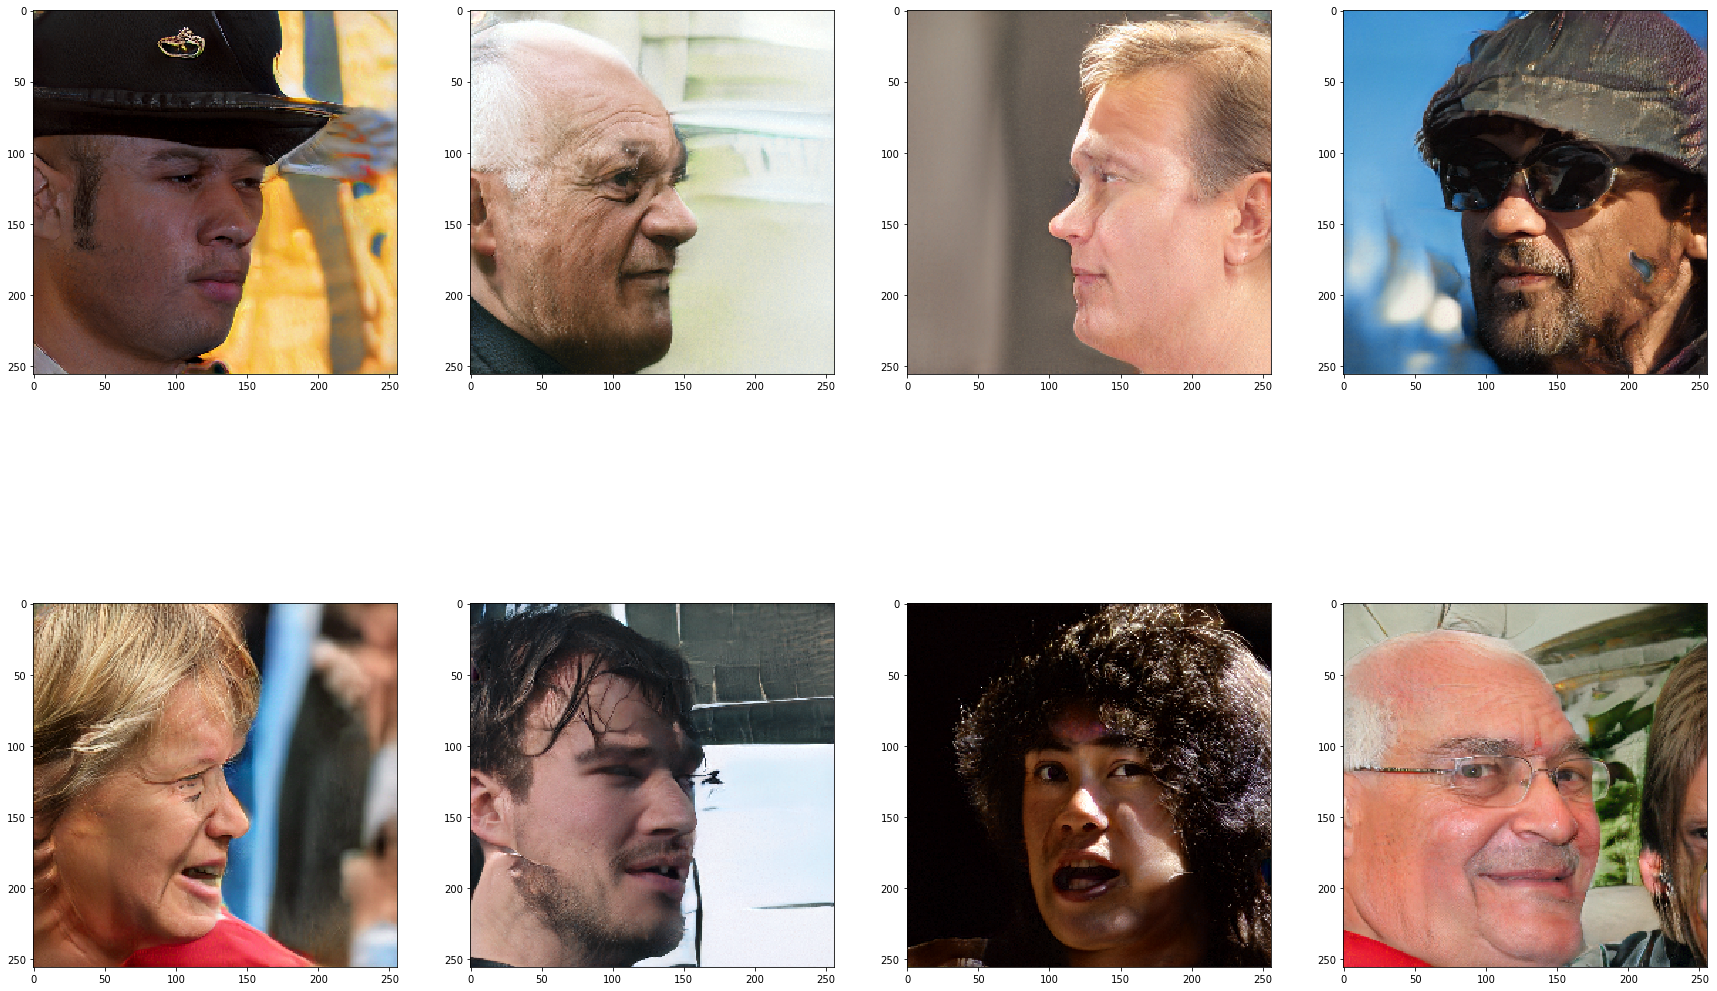

In [99]:
size = 256, 256
plt.figure(figsize=(30,20))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imgObj = load_img('./datasets/'+str(unable_crop[i+32])+'.png')
#     img = imgObj.thumbnail(size, Image.ANTIALIAS)
    plt.imshow(imgObj.resize(size))
plt.show()    

In [24]:
wrong_fat = list(set(file_fat).intersection(index_thin))
wrong_thin = list(set(file_thin).intersection(index_fat))
correct_fat = list(set(file_fat).intersection(index_fat))
correct_thin = list(set(file_thin).intersection(index_thin))

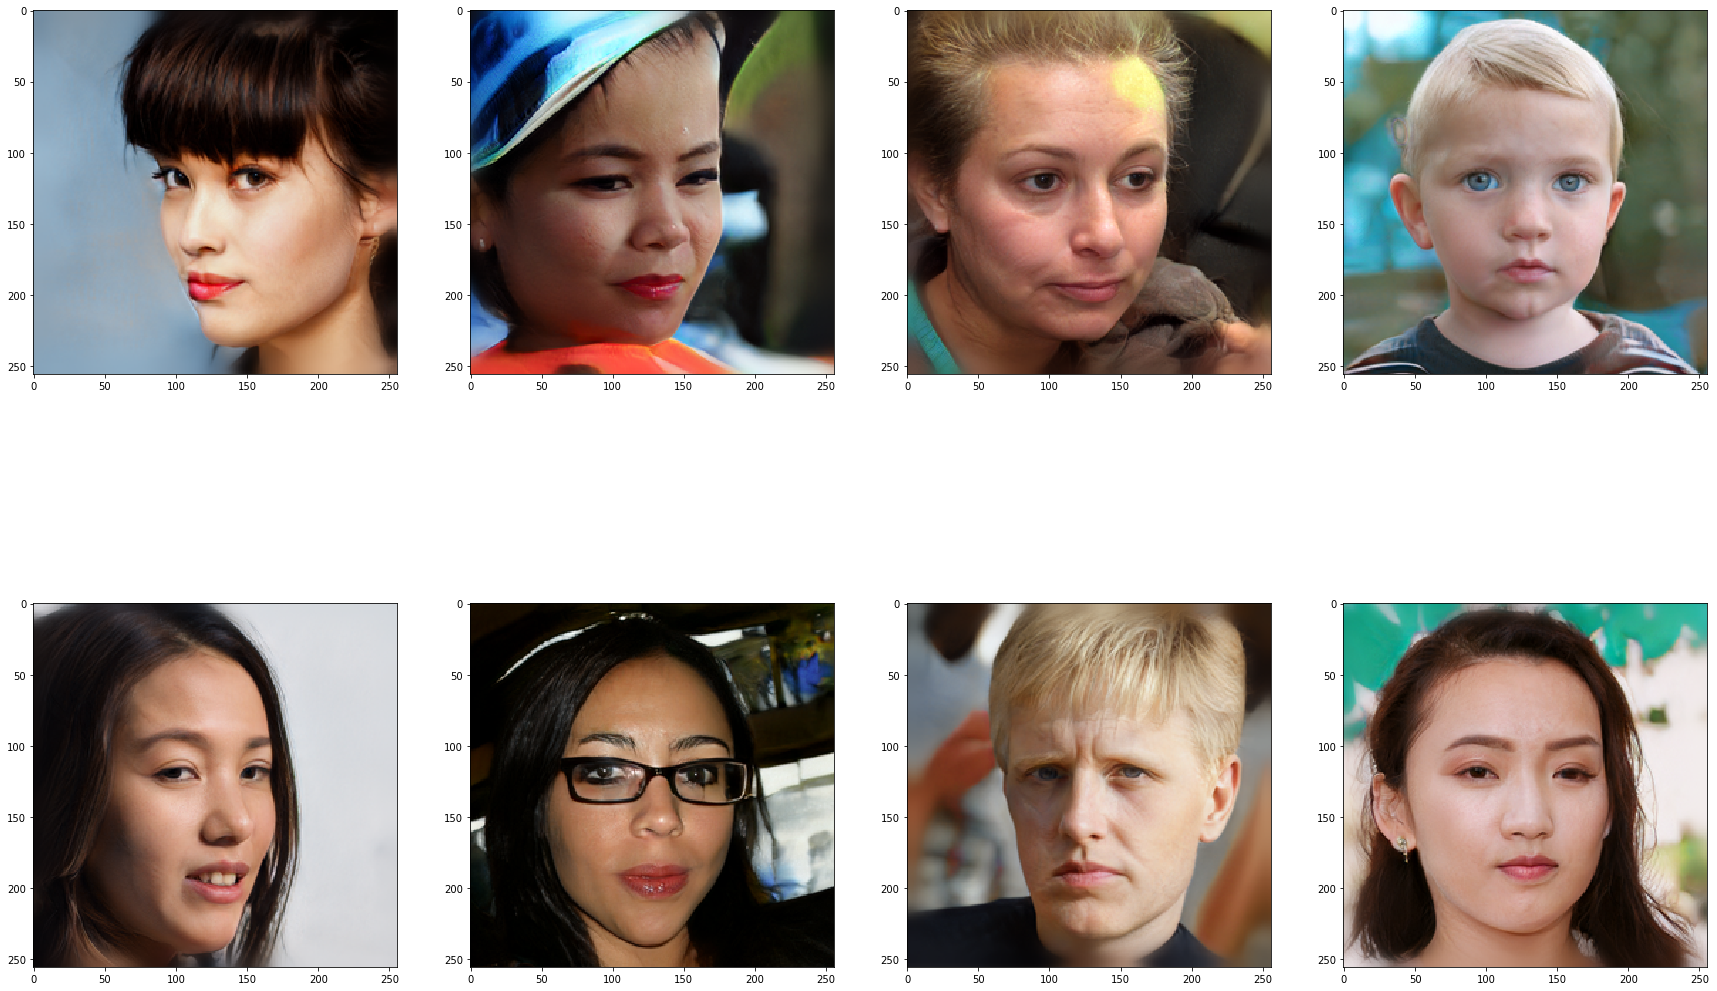

In [73]:
plt.figure(figsize=(30,20))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imgObj = load_img('./datasets_aligned/256/'+str(correct_thin[i+8])+'.png')
    plt.imshow(imgObj)
plt.show()    

In [14]:
# load-dlatents(X_data) 
dlatents_fat = dlatents[file_fat].reshape(-1,18*512)
dlatents_thin = dlatents[file_thin].reshape(-1,18*512)
print(dlatents_fat.shape, dlatents_thin.shape)
np.append(dlatents_fat, dlatents_thin, axis=0).shape
X_data = np.append(dlatents_fat, dlatents_thin, axis=0)
print(X_data.shape)

(5932, 9216) (3950, 9216)
(9882, 9216)


In [15]:
# load-predict label(in this case, already label manually)
y_weight_data = np.ones((9882,1)) #np.zero->fatten, ones-> thinning
print(y_weight_data.shape)
y_weight_data[0:5932] = [0.]
print(len(y_weight_data[y_weight_data == [1.]]))

(9882, 1)
3950


In [22]:
np.save('X_data_prediction.npy', X_data)
np.save('y_weight_data_prediction.npy', y_weight_data)

In [12]:
X_data = np.load('X_data_prediction.npy')
y_weight_data = np.load('y_weight_data_prediction.npy')

No handles with labels found to put in legend.


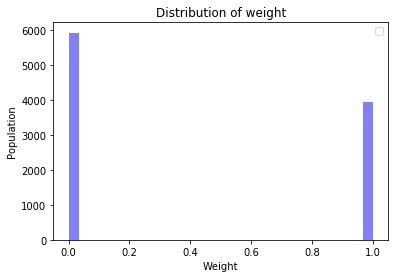

In [14]:
plt.hist(y_weight_data, bins=30, color='blue', alpha=0.5, )
plt.legend()
plt.title('Distribution of weight')
plt.xlabel('Weight')
plt.ylabel('Population')
plt.show()

In [145]:
# calculate the feature vector
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

clf = LogisticRegression(class_weight='balanced').fit(X_data, y_weight_data)
weight_nn_direction = clf.coef_.reshape((18, 512))
np.save('ffhq_dataset/latent_directions/thin_nn1.npy', weight_nn_direction)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [3]:
# load dataset- over 20k and more features
# 20307 generated images
qlatent_data, dlatent_data, labels_data = pickle.load(gzip.GzipFile(fileobj=open('./latent_training_data.pkl.gz', 'rb')))
print(len(labels_data))
labels_data[0]

20307


{'faceAttributes': {'accessories': [],
  'age': 50.0,
  'blur': {'blurLevel': 'low', 'value': 0.06},
  'emotion': {'anger': 0.0,
   'contempt': 0.0,
   'disgust': 0.0,
   'fear': 0.0,
   'happiness': 0.999,
   'neutral': 0.001,
   'sadness': 0.0,
   'surprise': 0.0},
  'exposure': {'exposureLevel': 'goodExposure', 'value': 0.71},
  'facialHair': {'beard': 0.1, 'moustache': 0.1, 'sideburns': 0.1},
  'gender': 'male',
  'glasses': 'NoGlasses',
  'hair': {'bald': 0.11,
   'hairColor': [{'color': 'brown', 'confidence': 1.0},
    {'color': 'gray', 'confidence': 0.65},
    {'color': 'blond', 'confidence': 0.36},
    {'color': 'black', 'confidence': 0.23},
    {'color': 'red', 'confidence': 0.2},
    {'color': 'other', 'confidence': 0.04}],
   'invisible': False},
  'headPose': {'pitch': 0.0, 'roll': -0.4, 'yaw': 3.1},
  'makeup': {'eyeMakeup': False, 'lipMakeup': False},
  'noise': {'noiseLevel': 'low', 'value': 0.09},
  'occlusion': {'eyeOccluded': False,
   'foreheadOccluded': False,
   'm

In [8]:
labels_data[0]['faceAttributes']['glasses']

'NoGlasses'

In [25]:
for index,value in enumerate(labels_data):
    str = value['faceAttributes']['glasses'] 
    if str.startswith('Swim'):
        print(str)
#         break


SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles
SwimmingGoggles


In [27]:
# select feature index
index_NoGlasses = [index for index,value in enumerate(labels_data) if value['faceAttributes']['glasses'] == 'NoGlasses']
print(len(index_NoGlasses))
index_ReadingGlasses = [index for index,value in enumerate(labels_data) if value['faceAttributes']['glasses'] == 'ReadingGlasses']
print(len(index_ReadingGlasses))
index_Sunglasses = [index for index,value in enumerate(labels_data) if value['faceAttributes']['glasses'] == 'Sunglasses']
print(len(index_Sunglasses))
index_SwimmingGoggles = [index for index,value in enumerate(labels_data) if value['faceAttributes']['glasses'] == 'SwimmingGoggles']
print(len(index_SwimmingGoggles))
print(len(index_NoGlasses)+len(index_ReadingGlasses)+len(index_Sunglasses)+len(index_SwimmingGoggles), len(labels_dataels_data))

16396
2979
903
29
20307 20307


In [35]:
# choose NoGlasses and ReadingGlasses
dlatents_no = dlatent_data[index_NoGlasses].reshape(-1,18*512) #0
dlatents_no_slipt = dlatents_no[0:1000]
# dlatents_reading = dlatent_data[index_ReadingGlasses].reshape(-1,18*512) #1
dlatents_sun = dlatent_data[index_Sunglasses].reshape(-1,18*512) #1
print(dlatents_no.shape,dlatents_no_slipt.shape, dlatents_sun.shape)

X_data = np.append(dlatents_no_slipt, dlatents_sun, axis=0)
print(X_data.shape)

(16396, 9216) (1000, 9216) (903, 9216)
(1903, 9216)


In [36]:
# set label of glasses
y_glasses_data = np.ones((1903,1))
print(y_glasses_data.shape)
y_glasses_data[0:1000] = [0.]
len(y_glasses_data[y_glasses_data == [1.]])

(1903, 1)


903

In [37]:
1gression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

clf = LogisticRegression(class_weight='balanced').fit(X_data, y_glasses_data)
glasses_direction = clf.coef_.reshape((18, 512))
np.save('ffhq_dataset/latent_directions/glasses.npy', glasses_direction)

### Manually labeled data

In [ ]:
# load-select usable pairs and find index
print(len(glob.glob("datasets_aligned/crop/fat/*.png")))
print(glob.glob("datasets_aligned/crop/fat/*.png")[0][26:-4])
index_fat = [int(i[26:-4]) for i in glob.glob("datasets_aligned/crop/fat/*.png")]
print(len(glob.glob("datasets_aligned/crop/non_fat/*.png")))
print(glob.glob("datasets_aligned/crop/non_fat/*.png")[0][30:-4])
index_thin = [int(i[30:-4]) for i in glob.glob("datasets_aligned/crop/non_fat/*.png")]

In [ ]:
# load-dlatents(X_data) 
dlatents_fat = dlatents[index_fat].reshape(-1,18*512)
dlatents_thin = dlatents[index_thin].reshape(-1,18*512)
print(dlatents_fat.shape, dlatents_thin.shape)
np.append(dlatents_fat, dlatents_thin, axis=0).shape
X_data = np.append(dlatents_fat, dlatents_thin, axis=0)

In [ ]:
# load-predict label(in this case, already label manually)
y_weight_data = np.zeros((9882,1))
print(y_weight_data.shape)
y_weight_data[0:5913] = [1.]
len(y_weight_data[y_weight_data == [0.]])

In [79]:
np.save('X_data_manually.npy', X_data)
np.save('y_weight_data_manually.npy', y_weight_data)

In [21]:
X_data = np.load('X_data_manually.npy')
y_weight_data = np.load('y_weight_data_manually.npy')

### compare with model prediction

In [15]:
dlatents_fat = dlatents[file_fat].reshape(-1,18*512)
dlatents_thin = dlatents[file_thin].reshape(-1,18*512)
print(dlatents_fat.shape, dlatents_thin.shape)
np.append(dlatents_fat, dlatents_thin, axis=0).shape
X_data = np.append(dlatents_fat, dlatents_thin, axis=0)
# load-predict label(in this case, already label manually)
y_weight_data = np.zeros((9882,1))
print(y_weight_data.shape)
y_weight_data[0:5931] = [1.]
len(y_weight_data[y_weight_data == [0.]])

NameError: name 'file_fat' is not defined

### distribution


No handles with labels found to put in legend.


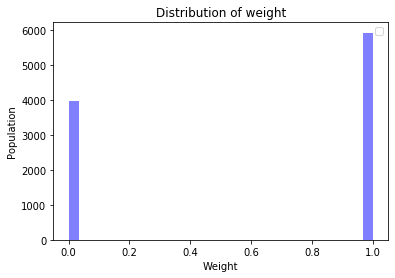

In [7]:
# show the distribution of feature prediction
plt.hist(y_weight_data, bins=30, color='blue', alpha=0.5, )
plt.legend()
plt.title('Distribution of weight')
plt.xlabel('Weight')
plt.ylabel('Population')
plt.show()

### feature vector from LR

In [53]:
# calculate the feature vector
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

clf = LogisticRegression(class_weight='balanced').fit(X_data, y_weight_data)
weight_direction = clf.coef_.reshape((18, 512))
np.save('ffhq_dataset/latent_directions/weight.npy', weight_direction)

ValueError: Found input variables with inconsistent numbers of samples: [9880, 9882]

### draw plot

In [18]:
import time
import numpy as np
import sklearn.linear_model as linear_model


def find_feature_axis(z, y, method='linear', **kwargs_model):
    """
    function to find axis in the latent space that is predictive of feature vectors

    :param z: vectors in the latent space, shape=(num_samples, num_latent_vector_dimension)
    :param y: feature vectors, shape=(num_samples, num_features)
    :param method: one of ['linear', 'logistic'], or a sklearn.linear_model object, (eg. sklearn.linear_model.ElasticNet)
    :param kwargs_model: parameters specific to a sklearn.linear_model object, (eg., penalty=’l2’)
    :return: feature vectors, shape = (num_latent_vector_dimension, num_features)
    """

    if method == 'linear':
        model = linear_model.LinearRegression(**kwargs_model)
        model.fit(z, y)
    elif method == 'tanh':
        def arctanh_clip(y):
            return np.arctanh(np.clip(y, np.tanh(-3), np.tanh(3)))

        model = linear_model.LinearRegression(**kwargs_model)

        model.fit(z, arctanh_clip(y))
    else:
        raise Exception('method has to be one of ["linear", "tanh"]')

    return model.coef_.transpose()


def normalize_feature_axis(feature_slope):
    """
    function to normalize the slope of features axis so that they have the same length

    :param feature_slope: array of feature axis, shape = (num_latent_vector_dimension, num_features)
    :return: same shape of input
    """

    feature_direction = feature_slope / np.linalg.norm(feature_slope, ord=2, axis=0, keepdims=True)
    return feature_direction


def disentangle_feature_axis(feature_axis_target, feature_axis_base, yn_base_orthogonalized=False):
    """
    make feature_axis_target orthogonal to feature_axis_base

    :param feature_axis_target: features axes to decorrerelate, shape = (num_dim, num_feature_0)
    :param feature_axis_base: features axes to decorrerelate, shape = (num_dim, num_feature_1))
    :param yn_base_orthogonalized: True/False whether the feature_axis_base is already othogonalized
    :return: feature_axis_decorrelated, shape = shape = (num_dim, num_feature_0)
    """

    # make sure this funciton works to 1D vector
    if len(feature_axis_target.shape) == 0:
        yn_single_vector_in = True
        feature_axis_target = feature_axis_target[:, None]
    else:
        yn_single_vector_in = False

    # if already othogonalized, skip this step
    if yn_base_orthogonalized:
        feature_axis_base_orthononal = orthogonalize_vectors(feature_axis_base)
    else:
        feature_axis_base_orthononal = feature_axis_base

    # orthogonalize every vector
    feature_axis_decorrelated = feature_axis_target + 0
    num_dim, num_feature_0 = feature_axis_target.shape
    num_dim, num_feature_1 = feature_axis_base_orthononal.shape
    for i in range(num_feature_0):
        for j in range(num_feature_1):
            feature_axis_decorrelated[:, i] = orthogonalize_one_vector(feature_axis_decorrelated[:, i],
                                                                       feature_axis_base_orthononal[:, j])

    # make sure this funciton works to 1D vector
    if yn_single_vector_in:
        result = feature_axis_decorrelated[:, 0]
    else:
        result = feature_axis_decorrelated

    return result


def disentangle_feature_axis_by_idx(feature_axis, idx_base=None, idx_target=None, yn_normalize=True):
    """
    disentangle correlated feature axis, make the features with index idx_target orthogonal to
    those with index idx_target, wrapper of function disentangle_feature_axis()

    :param feature_axis:       all features axis, shape = (num_dim, num_feature)
    :param idx_base:           index of base features (1D numpy array), to which the other features will be orthogonal
    :param idx_target: index of features to disentangle (1D numpy array), which will be disentangled from
                                    base features, default to all remaining features
    :param yn_normalize:       True/False to normalize the results
    :return:                   disentangled features, shape = feature_axis
    """

    (num_dim, num_feature) = feature_axis.shape

    # process default input
    if idx_base is None or len(idx_base) == 0:    # if None or empty, do nothing
        feature_axis_disentangled = feature_axis
    else:                                         # otherwise, disentangle features
        if idx_target is None:                # if None, use all remaining features
            idx_target = np.setdiff1d(np.arange(num_feature), idx_base)

        feature_axis_target = feature_axis[:, idx_target] + 0
        feature_axis_base = feature_axis[:, idx_base] + 0
        feature_axis_base_orthogonalized = orthogonalize_vectors(feature_axis_base)
        feature_axis_target_orthogonalized = disentangle_feature_axis(
            feature_axis_target, feature_axis_base_orthogonalized, yn_base_orthogonalized=True)

        feature_axis_disentangled = feature_axis + 0  # holder of results
        feature_axis_disentangled[:, idx_target] = feature_axis_target_orthogonalized
        feature_axis_disentangled[:, idx_base] = feature_axis_base_orthogonalized

    # normalize output
    if yn_normalize:
        feature_axis_out = normalize_feature_axis(feature_axis_disentangled)
    else:
        feature_axis_out = feature_axis_disentangled
    return feature_axis_out


def orthogonalize_one_vector(vector, vector_base):
    """
    tool function, adjust vector so that it is orthogonal to vector_base (i.e., vector - its_projection_on_vector_base )

    :param vector0: 1D array
    :param vector1: 1D array
    :return: adjusted vector1
    """
    return vector - np.dot(vector, vector_base) / np.dot(vector_base, vector_base) * vector_base


def orthogonalize_vectors(vectors):
    """
    tool function, adjust vectors so that they are orthogonal to each other, takes O(num_vector^2) time

    :param vectors: vectors, shape = (num_dimension, num_vector)
    :return: orthorgonal vectors, shape = (num_dimension, num_vector)
    """
    vectors_orthogonal = vectors + 0
    num_dimension, num_vector = vectors.shape
    for i in range(num_vector):
        for j in range(i):
            vectors_orthogonal[:, i] = orthogonalize_one_vector(vectors_orthogonal[:, i], vectors_orthogonal[:, j])
    return vectors_orthogonal


def plot_feature_correlation(feature_direction, feature_name=None):
    import matplotlib.pyplot as plt

    len_z, len_y = feature_direction.shape
    if feature_name is None:
        feature_name = range(len_y)

    feature_correlation = np.corrcoef(feature_direction.transpose())

    c_lim_abs = np.max(np.abs(feature_correlation))

    plt.pcolormesh(np.arange(len_y+1), np.arange(len_y+1), feature_correlation,
                   cmap='coolwarm', vmin=-c_lim_abs, vmax=+c_lim_abs)
    plt.gca().invert_yaxis()
    plt.colorbar()
    # plt.axis('square')
    plt.xticks(np.arange(len_y) + 0.5, feature_name, fontsize='x-small', rotation='vertical')
    plt.yticks(np.arange(len_y) + 0.5, feature_name, fontsize='x-small')
    plt.show()


def plot_feature_cos_sim(feature_direction, feature_name=None):
    """
    plot cosine similarity measure of vectors

    :param feature_direction: vectors, shape = (num_dimension, num_vector)
    :param feature_name:      list of names of features
    :return:                  cosines similarity matrix, shape = (num_vector, num_vector)
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics.pairwise import cosine_similarity

    len_z, len_y = feature_direction.shape
    if feature_name is None:
        feature_name = range(len_y)

    feature_cos_sim = cosine_similarity(feature_direction.transpose())

    c_lim_abs = np.max(np.abs(feature_cos_sim))

    plt.pcolormesh(np.arange(len_y+1), np.arange(len_y+1), feature_cos_sim,
                   vmin=-c_lim_abs, vmax=+c_lim_abs, cmap='coolwarm')
    plt.gca().invert_yaxis()
    plt.colorbar()
    # plt.axis('square')
    plt.xticks(np.arange(len_y) + 0.5, feature_name, fontsize='x-small', rotation='vertical')
    plt.yticks(np.arange(len_y) + 0.5, feature_name, fontsize='x-small')
    plt.show()
    return feature_cos_sim


In [19]:
# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')
weight_direction = np.load('ffhq_dataset/latent_directions/weight.npy')
weight_nn_direction = np.load('ffhq_dataset/latent_directions/weight_nn.npy')
weight_nn_all_direction = np.load('ffhq_dataset/latent_directions/weight_nn_all.npy')
glasses_direction = np.load('ffhq_dataset/latent_directions/glasses.npy')

In [20]:
weight = weight_direction[0]
weight_nn = weight_nn_direction[0]
weight_nn_all = weight_nn_all_direction[0]
gender = gender_direction[0]
age = age_direction[0]
mouth = smile_direction[0]

In [58]:
weight_nn_orth_mouth = orthogonalize_one_vector(weight_nn_all, mouth)
np.save('ffhq_dataset/latent_directions/weight_nn_all_orth_mouth.npy', weight_nn_orth_mouth)

In [8]:
weight_orth_gender = orthogonalize_one_vector(weight, gender)

In [10]:
np.save('ffhq_dataset/latent_directions/weight_orth_gender.npy', weight_orth_gender)

In [40]:
np.transpose(np.vstack((weight, gender,age))).shape


(512, 3)

### Feature correlation

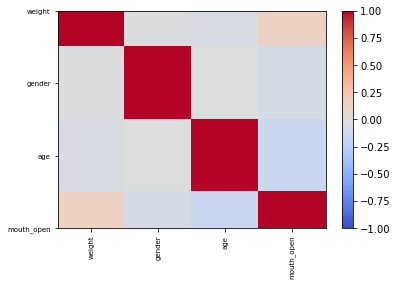

In [21]:
plot_feature_correlation(np.transpose(np.vstack((weight, gender,age,mouth))), ['weight', 'gender','age','mouth_open'])

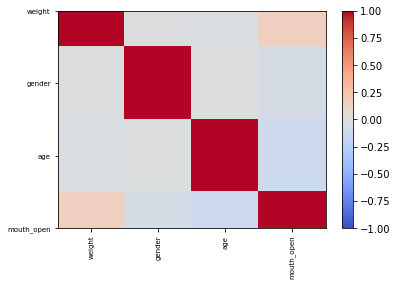

array([[ 1.        , -0.01519824, -0.02847784,  0.15678814],
       [-0.01519824,  1.        , -0.00508065, -0.06023129],
       [-0.02847784, -0.00508065,  1.        , -0.11711123],
       [ 0.15678814, -0.06023129, -0.11711123,  1.        ]])

In [22]:
plot_feature_cos_sim(np.transpose(np.vstack((weight, gender,age,mouth))), ['weight', 'gender','age','mouth_open'])

In [43]:
weight_orth_mouth = orthogonalize_one_vector(weight, mouth)
np.save('ffhq_dataset/latent_directions/weight_orth_mouth.npy', weight_orth_mouth)

In [44]:
weight_orth_age = orthogonalize_one_vector(weight, age)
np.save('ffhq_dataset/latent_directions/weight_orth_age.npy', weight_orth_age)

In [45]:
weight_orth = orthogonalize_vectors(np.transpose(np.vstack((weight, gender,age,mouth))))[:,0]
np.save('ffhq_dataset/latent_directions/weight_orth.npy', weight_orth)

In [61]:
weight_nn_orth = orthogonalize_vectors(np.transpose(np.vstack((weight_nn, gender,age,mouth))))[:,0]
np.save('ffhq_dataset/latent_directions/weight_nn_orth.npy', weight_nn_orth)

In [62]:
weight_nn_orth_age = orthogonalize_one_vector(weight_nn, age)
np.save('ffhq_dataset/latent_directions/weight_nn_orth_age.npy', weight_nn_orth_age)

### NonLinear

In [8]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Activation,BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.initializers import RandomNormal

In [9]:
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [22]:
X_data_row = np.zeros((X_data.shape[0],512))
for i in range(X_data.shape[0]):
    X_data_row[i] = X_data[i][:512]
X_data_row.shape

(9882, 512)

In [26]:
build = Sequential()


build.add(Dense(512, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0625, seed=None), 
                kernel_regularizer=regularizers.l2(0.0001)))
build.add(BatchNormalization())
build.add(Dropout(0.3))
build.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
build.add(BatchNormalization())
build.add(Dropout(0.3))


build.add(Dense(1))
build.add(Activation('sigmoid'))
build.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = build.fit(X_data_row.reshape((-1, 512)), y_weight_data, validation_split=0.2, epochs=15)
build = Model(build.input, build.layers[-2].output)

# works bit better, but in general accuracy is quite similar to the linear model

Train on 7905 samples, validate on 1977 samples
Epoch 1/15
7905/7905 [==============================] - 3s 419us/step - loss: 0.6987 - accuracy: 0.7175 - val_loss: 1.0942 - val_accuracy: 0.3278
Epoch 2/15
7905/7905 [==============================] - 3s 361us/step - loss: 0.5386 - accuracy: 0.8053 - val_loss: 1.0753 - val_accuracy: 0.4664
Epoch 3/15
7905/7905 [==============================] - 3s 330us/step - loss: 0.5024 - accuracy: 0.8243 - val_loss: 1.0693 - val_accuracy: 0.4876
Epoch 4/15
7905/7905 [==============================] - 3s 351us/step - loss: 0.4730 - accuracy: 0.8338 - val_loss: 1.1262 - val_accuracy: 0.4507
Epoch 5/15
7905/7905 [==============================] - 2s 303us/step - loss: 0.4522 - accuracy: 0.8459 - val_loss: 1.0679 - val_accuracy: 0.5180
Epoch 6/15
7905/7905 [==============================] - 3s 346us/step - loss: 0.4326 - accuracy: 0.8539 - val_loss: 1.0531 - val_accuracy: 0.5352
Epoch 7/15
7905/7905 [==============================] - 3s 337us/step - loss

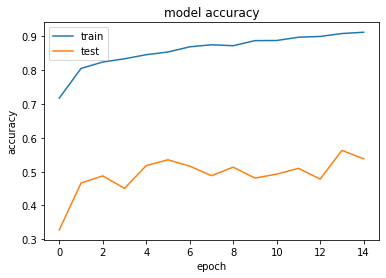

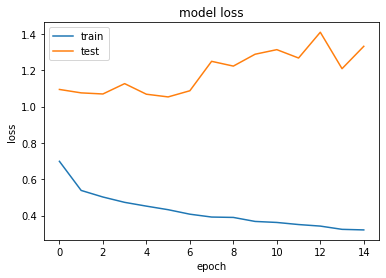

In [27]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='middle right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='middle right')
plt.show()

In [44]:
embedding_model = Sequential()
embedding_model.add(Embedding(10, 18*512, input_length=1)) # it's actually just a variable
embedding_model.add(Flatten())

nonliner_weight_model = Model(embedding_model.input, build(embedding_model.output))
nonliner_weight_model.layers[-1].trainable = False # fix non-linear model and train only embeddings
nonliner_weight_model.compile('sgd', 'mse')

nonliner_weight_model.layers[1].set_weights([X_data[:10].reshape((-1, 18*512))])
y_data_real = nonliner_weight_model.predict(np.arange(10))
y_data_real

array([[ 0.4975396 ],
       [-3.046778  ],
       [-3.670952  ],
       [-1.3329594 ],
       [-4.1670427 ],
       [-0.34993753],
       [-5.6164546 ],
       [-0.9802468 ],
       [-2.8235023 ],
       [-1.8507066 ]], dtype=float32)

In [45]:
nonliner_weight_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3_input (InputLaye (None, 1)                 0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1, 9216)           92160     
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
model_8 (Model)              (None, 1)                 9574145   
Total params: 9,666,305
Trainable params: 92,160
Non-trainable params: 9,574,145
_________________________________________________________________


In [46]:
embedding_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1, 9216)           92160     
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


In [47]:
nonliner_weight_model.fit(np.arange(10), np.full((10, 1), 20), verbose=0, epochs=500)
nonliner_weight_model.predict(np.arange(10))

array([[-2.1441152],
       [-2.2262592],
       [-3.0455272],
       [-2.170907 ],
       [-3.3335285],
       [-1.8206165],
       [-2.5970592],
       [-1.9748064],
       [-2.4723258],
       [-2.0899458]], dtype=float32)

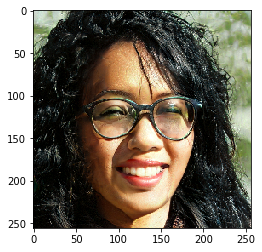

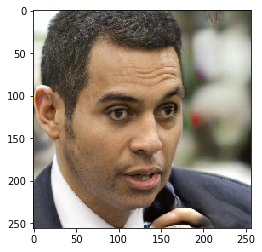

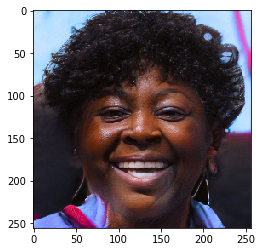

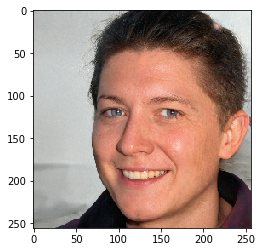

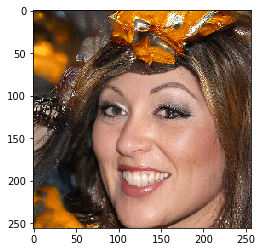

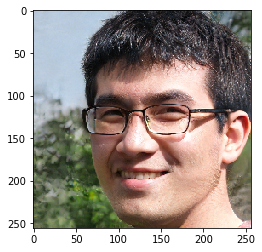

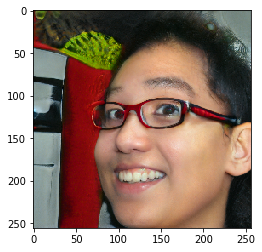

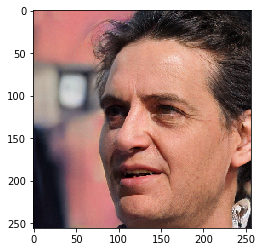

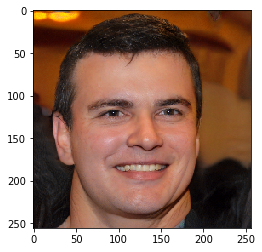

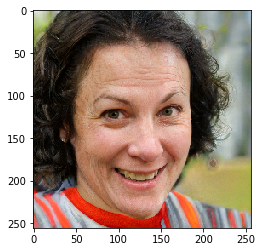

In [48]:
for v in embedding_model.layers[0].get_weights()[0]:
    plt.imshow(generate_image(v))
    plt.show()

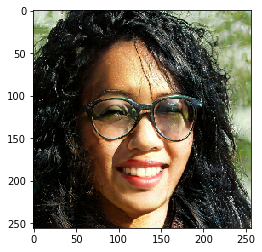

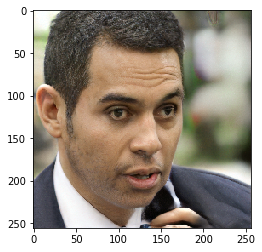

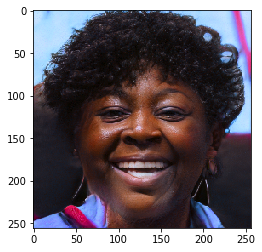

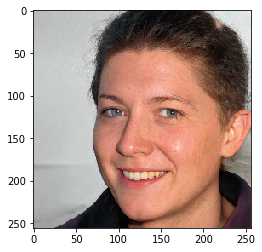

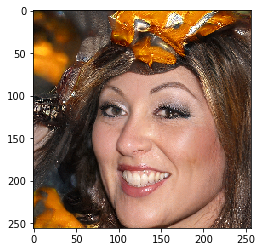

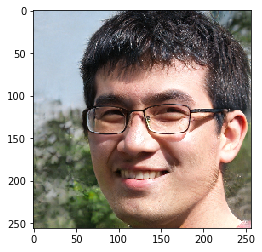

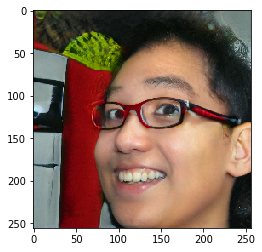

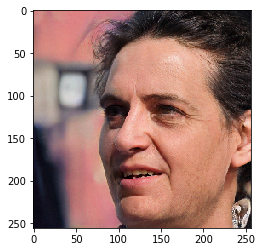

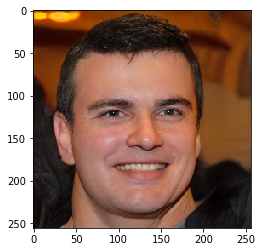

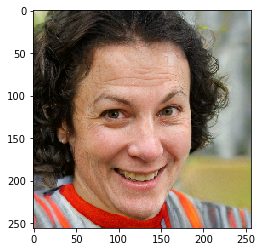

In [49]:
# reset latents and try it over but now in another direction 
nonliner_weight_model.layers[1].set_weights([X_data[:10].reshape((-1, 18*512))])

nonliner_weight_model.fit(np.arange(10), np.full((10, 1), -100), verbose=0, epochs=500)

for v in embedding_model.layers[0].get_weights()[0]:
    plt.imshow(generate_image(v))
    plt.show()